## Read depth model
Modeled as zero inflated negative binomial distribution

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import betabinom
import numpy as np
from scipy.special import logsumexp
from collections import Counter

In [3]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)
coverage = reference.fillna(0) + alternative.fillna(0)
vaf = alternative/(alternative+reference).fillna(0)

In [4]:
def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

# learned from mm34 scRNA seq dataset
mu, theta, pi = 60, 0.17, 0.38
synthetic_data = sample_zinb(mu, theta, pi, size=10000)

We have to deal with a very large proportion of zero read depths

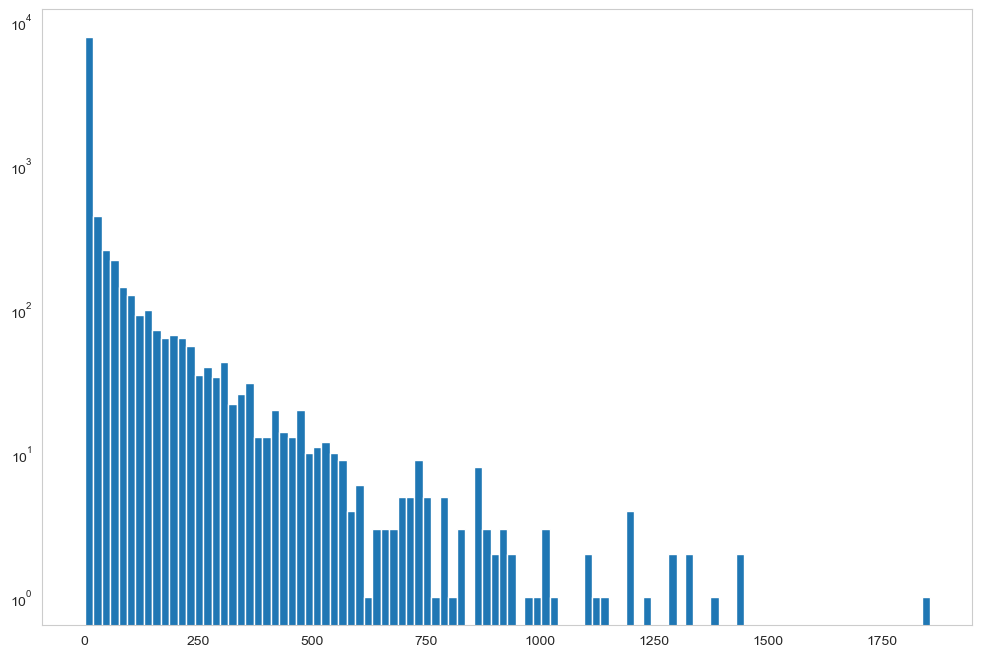

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(synthetic_data, bins=100)
plt.yscale('log')
plt.grid(False)
plt.show()

## VAF simulation

1. Homozygous alternative genotype
2. Homozygous reference genotype
3. Heterozygous genotype

1. Homozygous reference genotype

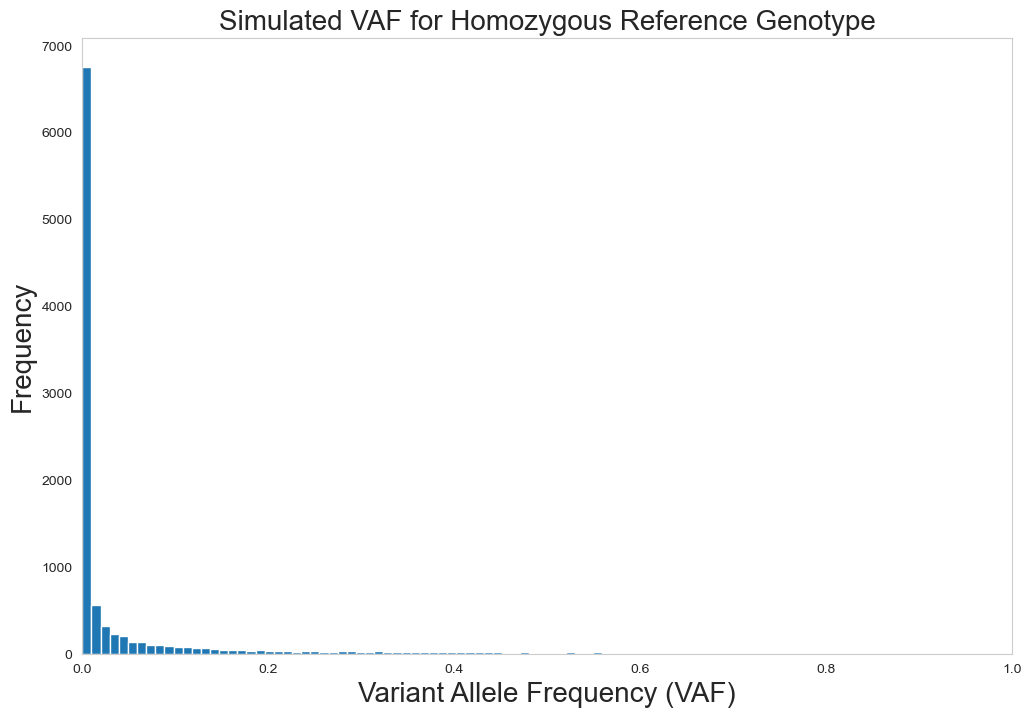

In [6]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = error_rate * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Reference Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

2. Homozygous alternative genotype

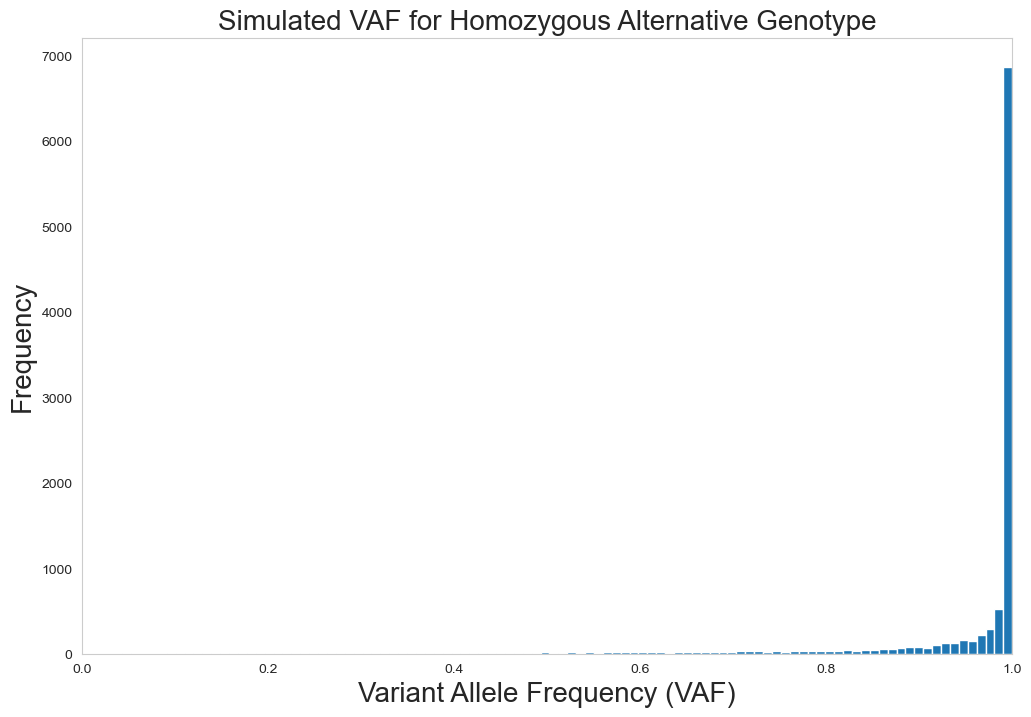

In [7]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

3. Heterozygous genotype

Technical dropout

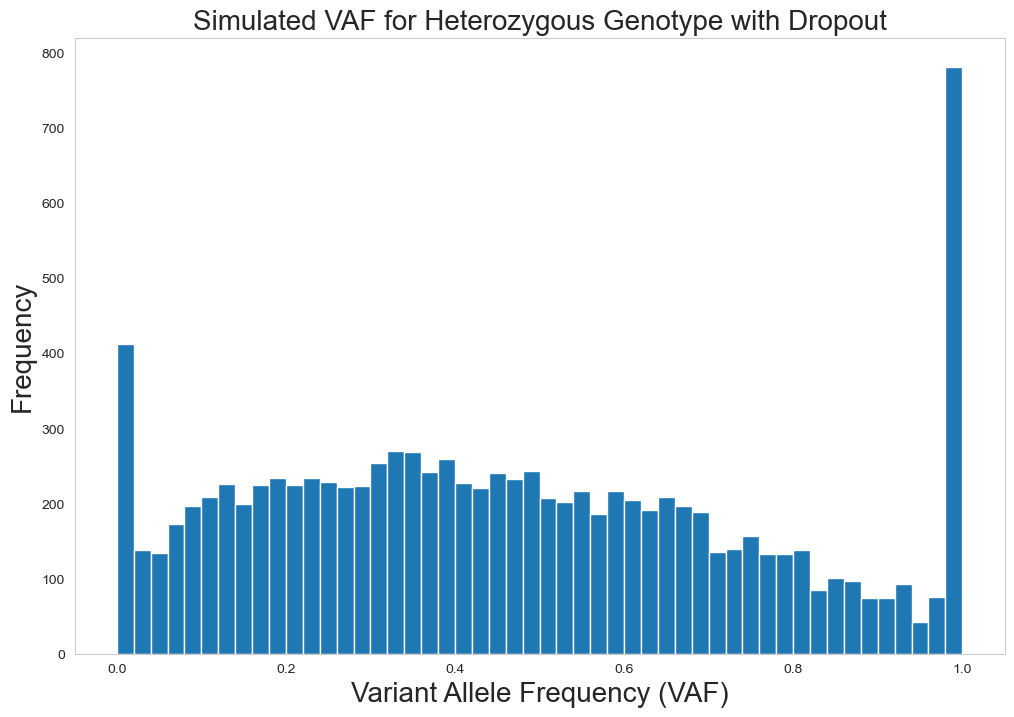

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom, bernoulli

def simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion):
    """
    Simulates VAF counts for a heterozygous genotype considering dropout and overdispersion.
    
    Parameters:
    - alpha: Shape parameter of the Beta distribution.
    - beta: Shape parameter of the Beta distribution.
    - dropout_prob: Probability of a technical dropout.
    - dropout_direction_prob: Probability the dropout favors the reference allele.
    - N: Read depth
    - num_simulations: Number of VAF simulations.
    - error_rate: Error rate for monoallelic expressed genes
    - overdispersion: Overdispersion parameter for monoallelic expressed genes
    
    
    Returns:
    - vaf_counts: Array of simulated VAF counts (variant reads).
    """
    vaf_counts = []
    
    for _ in range(num_simulations):
        # Check if a dropout occurs
        is_dropout = bernoulli.rvs(dropout_prob)
        
        if is_dropout:
            # Sample dropout direction (reference or alternative allele)
            dropout_direction = bernoulli.rvs(dropout_direction_prob)
            
            # If dropout favors reference, all reads are reference (0 alt reads)
            # If dropout favors alternative, all reads are alternative (N alt reads)
            if dropout_direction == 1:
                alpha_seq = (1-error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = 0
            else:
                alpha_seq = (error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = N
        
        else:
            # No dropout: use Beta-Binomial distribution to simulate alt reads
            alt_reads = betabinom.rvs(N, alpha, beta)
        
        vaf_counts.append(alt_reads) 
         
    vaf_counts = np.array(vaf_counts)/N
    
    return vaf_counts

# Parameters
alpha = 1.5               # Beta distribution alpha parameter
beta = 2                # Beta distribution beta parameter
dropout_prob = 0.15      # Probability of a technical dropout
dropout_direction_prob = 0.7  # Probability dropout favors reference allele
error_rate = 0.05       # Sequencing error rate
overdispersion = 2      # Overdispersion of sequencing errors.
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

# Simulate VAF counts
vaf_counts = simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Simulated VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

Ground Truth Parameters:
f_AA: 0.6000, f_Aa: 0.3000, f_aa: 0.1000
Simulated Read Counts: Counter({'AA': 599, 'Aa': 305, 'aa': 96})

Estimated Parameters:
f_AA: 0.6008, f_Aa: 0.3044, f_aa: 0.0948
Observed Read Counts: Counter({0: 562, 1: 356, 2: 82})


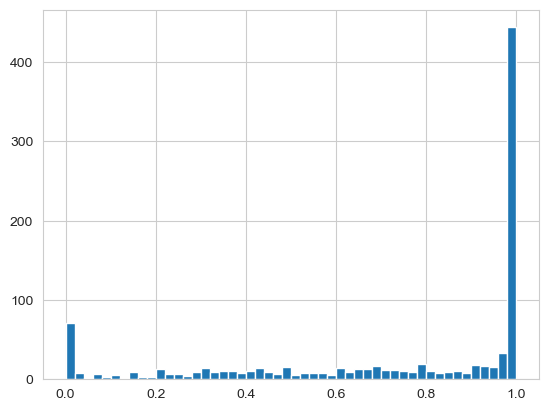

In [9]:
def beta_binomial_params(overdispersion, error_rate, genotype):
    """
    Computes the Beta-Binomial parameters for a given genotype.
    """
    if genotype == "AA":  # Homozygous reference
        alpha = (1 - error_rate) * overdispersion
        beta = overdispersion - alpha
    elif genotype == "aa":  # Homozygous alternative
        alpha = error_rate * overdispersion
        beta = overdispersion - alpha
    return alpha, beta

def genotype_probability(k, N, overdispersion, error_rate, genotype, alpha_h, beta_h):
    """
    Computes the probability of observing `k` alternative reads given genotype.
    """
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    return betabinom.pmf(k, N, alpha, beta)

def e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h):
    """
    E-Step: Computes the responsibilities for each genotype given observations.
    """
    responsibilities = []
    for k, n in zip(k_obs, N):
        # Compute unnormalized posterior probabilities for each genotype
        log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
        log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
        log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
        
        # Use log-sum-exp trick for numerical stability
        log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
        
        # Compute responsibilities
        resp_AA = np.exp(log_p_AA - log_total)
        resp_Aa = np.exp(log_p_Aa - log_total)
        resp_aa = np.exp(log_p_aa - log_total)
        
        responsibilities.append([resp_AA, resp_Aa, resp_aa])
    
    return np.array(responsibilities)

def m_step(responsibilities):
    """
    M-Step: Updates genotype frequencies based on responsibilities.
    """
    f_AA = np.mean(responsibilities[:, 0])
    f_Aa = np.mean(responsibilities[:, 1])
    f_aa = np.mean(responsibilities[:, 2])
    return f_AA, f_Aa, f_aa

def em_algorithm_fixed_params(k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h, min_iterations=10, max_iterations=100, tolerance=1e-6):
    """
    Runs the EM algorithm to estimate genotype proportions with fixed parameters.
    """
    f_AA, f_Aa, f_aa = f_AA_init, f_Aa_init, f_aa_init
    prev_log_likelihood = None
    
    for iteration in range(max_iterations):
        # E-Step
        responsibilities = e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h)
        
        # M-Step
        f_AA, f_Aa, f_aa = m_step(responsibilities)
        
        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for k, n, resp in zip(k_obs, N, responsibilities):
            log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
            log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
            log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
            log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
            log_likelihood += log_total
        
        # Check convergence
        if iteration >= min_iterations:  # Only check convergence after min_iterations
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
                break
        
        prev_log_likelihood = log_likelihood
    
    return f_AA, f_Aa, f_aa, responsibilities

# Parameters
np.random.seed(42)
num_simulations = 1000
overdispersion = 2
error_rate = 0.05
alpha_h, beta_h = 2, 2  # Heterozygous Beta-Binomial parameters
f_AA_true, f_Aa_true, f_aa_true = 0.6, 0.3, 0.1

# Simulate varying read depths
N = np.random.randint(500, 1500, size=num_simulations)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=num_simulations, p=[f_AA_true, f_Aa_true, f_aa_true])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))

# Run EM algorithm with fixed parameters
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3
f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)

# Observed read counts
observed_counts = Counter(np.argmax(responsibilities, axis=1))
total_simulations = sum(observed_counts.values())

# Results
print("Ground Truth Parameters:")
print(f"f_AA: {f_AA_true:.4f}, f_Aa: {f_Aa_true:.4f}, f_aa: {f_aa_true:.4f}")
print(f"Simulated Read Counts: {read_counts}")
print("\nEstimated Parameters:")
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")
print(f"Observed Read Counts: {observed_counts}")

plt.hist(k_obs/N, bins=50)
plt.show()

f_AA: 0.5084, f_Aa: 0.1861, f_aa: 0.3055


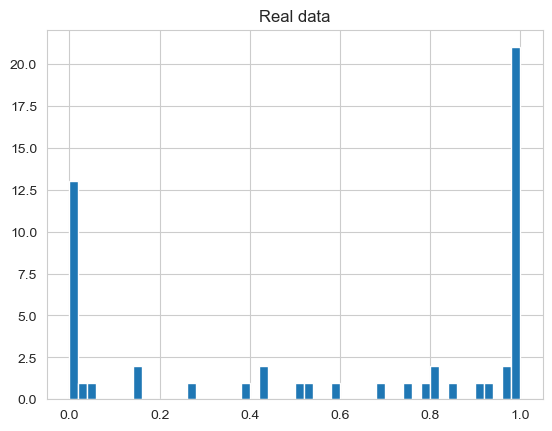

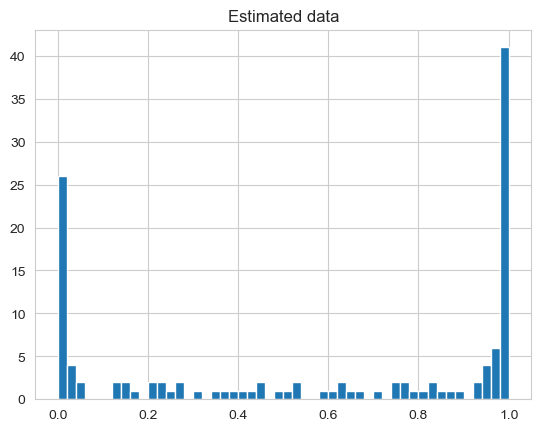

In [10]:
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3

non_zero_indices = np.where(coverage.iloc[:, 0] > 0)[0]
N_nonzero = np.array(coverage)[:, 0][non_zero_indices]
k_obs_nonzero = np.array(alternative)[:, 0][non_zero_indices]

f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs_nonzero, N_nonzero, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")

n_cells = 127
N = np.random.randint(500, 1500, size=n_cells)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=n_cells, p=[f_AA_est, f_Aa_est, f_aa_est])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))
    
plt.hist(vaf.iloc[:, 0], bins=50)
plt.title("Real data")
plt.show()

plt.hist(k_obs/N, bins=50)
plt.title("Estimated data")
plt.show()

In [11]:
import numpy as np
from scipy.special import gammaln, logsumexp
from scipy.optimize import minimize_scalar

# Log likelihood for Beta-Binomial
def beta_binomial_log_likelihood(k, n, alpha, beta):
    """
    Computes the log-likelihood for a single Beta-Binomial observation.
    """
    log_coeff = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    log_beta = gammaln(alpha + k) + gammaln(beta + n - k) - gammaln(alpha + beta + n)
    log_beta_norm = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)
    return log_coeff + log_beta - log_beta_norm

In [12]:
all_alt_counts = [0.0, 0.0, 6.0, 0.0, 4.0, 8.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 1.0, 0.0, 0.0, 0.0, 0.0, 71.0, 2.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 21.0, 0.0, 0.0, 0.0, 4.0, 19.0, 1.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 23.0, 275.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 124.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 0.0, 0.0, 435.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 78.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 48.0, 0.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 59.0, 0.0, 1.0, 0.0, 48.0, 0.0, 3.0, 0.0, 28.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 487.0, 1.0, 0.0, 0.0, 8.0, 5.0, 0.0, 0.0, 1.0, 0.0, 23.0, 0.0, 21.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 4.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 33.0, 0.0, 0.0, 113.0, 0.0, 152.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 110.0, 0.0, 12.0, 0.0, 8.0, 0.0, 2.0, 0.0, 1.0, 143.0, 1.0, 1.0, 5.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 71.0, 3.0, 0.0, 0.0, 222.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 2.0, 1.0, 0.0, 8.0, 0.0, 48.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 12.0, 0.0, 0.0, 0.0, 31.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 86.0, 514.0, 0.0, 0.0, 292.0, 0.0, 134.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 1.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 16.0, 6.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 20.0, 1.0, 0.0, 4.0, 32.0, 1.0, 0.0, 41.0, 21.0, 4.0, 0.0, 2.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 952.0, 9.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 462.0, 0.0, 0.0, 0.0, 0.0, 58.0, 6.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 143.0, 0.0, 0.0, 89.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 123.0, 0.0, 0.0, 0.0, 28.0, 0.0, 46.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 92.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 27.0, 34.0, 40.0, 1.0, 0.0, 0.0, 0.0, 0.0, 102.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 34.0, 7.0, 0.0, 2.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 405.0, 0.0, 0.0, 523.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 125.0, 31.0, 2.0, 0.0, 501.0, 0.0, 0.0, 13.0, 25.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 228.0, 330.0, 0.0, 0.0, 36.0, 12.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 79.0, 118.0, 7.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 41.0, 13.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 2.0, 197.0, 0.0, 297.0, 276.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 6.0, 0.0, 0.0, 28.0, 51.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 27.0, 237.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 15.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 121.0, 0.0, 7.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 109.0, 0.0, 351.0, 461.0, 0.0, 0.0, 103.0, 0.0, 0.0, 0.0, 148.0, 0.0, 2.0, 0.0, 0.0, 0.0, 121.0, 0.0, 1.0, 0.0, 0.0, 0.0, 328.0, 1.0, 0.0, 485.0, 3.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 2.0, 0.0, 162.0, 0.0, 1.0, 1.0, 1.0, 18.0, 5.0, 34.0, 2.0, 0.0, 0.0, 17.0, 0.0, 27.0, 8.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 134.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 206.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 3.0, 0.0, 16.0, 0.0, 0.0, 147.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 2.0, 26.0, 26.0, 21.0, 0.0, 0.0, 1.0, 0.0, 0.0, 9.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 306.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.0, 0.0, 189.0, 0.0, 143.0, 0.0, 42.0, 1.0, 0.0, 0.0, 0.0, 0.0, 77.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 2.0, 23.0, 38.0, 0.0, 0.0, 0.0, 8.0, 0.0, 66.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 6.0, 3.0, 0.0, 105.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 12.0, 0.0, 2.0, 0.0, 25.0, 4.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 440.0, 0.0, 612.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 272.0, 23.0, 414.0, 10.0, 0.0, 0.0, 0.0, 0.0, 3.0, 95.0, 0.0, 0.0, 0.0, 127.0, 0.0, 44.0, 0.0, 88.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 31.0, 0.0, 75.0, 16.0, 0.0, 10.0, 44.0, 494.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 162.0, 0.0, 1.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 11.0, 0.0, 0.0, 10.0, 0.0, 53.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 102.0, 0.0, 17.0, 12.0, 0.0, 0.0, 0.0, 37.0, 0.0, 39.0, 4.0, 0.0, 0.0, 36.0, 31.0, 0.0, 152.0, 37.0, 0.0, 0.0, 285.0, 0.0, 19.0, 0.0, 1.0, 0.0, 0.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 19.0, 11.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 16.0, 0.0, 0.0, 2.0, 0.0, 174.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 0.0, 0.0, 0.0, 0.0, 5.0, 345.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 19.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 432.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 677.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 15.0, 0.0, 0.0, 0.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0, 511.0, 0.0, 0.0, 118.0, 0.0, 0.0, 181.0, 0.0, 6.0, 20.0, 0.0, 0.0, 10.0, 0.0, 109.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 260.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 171.0, 14.0, 64.0, 0.0, 271.0, 0.0, 194.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 2.0, 0.0, 0.0, 9.0, 0.0, 0.0, 8.0, 0.0, 4.0, 0.0, 456.0, 50.0, 7.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 57.0, 0.0, 0.0, 0.0, 0.0, 6.0, 3.0, 331.0, 0.0, 0.0, 46.0, 0.0, 5.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 0.0, 17.0, 0.0, 58.0, 0.0, 0.0, 0.0, 2.0, 0.0, 67.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 316.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 2.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 13.0, 0.0, 0.0, 20.0, 0.0, 0.0, 310.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 132.0, 0.0, 0.0, 12.0, 68.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 3.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 22.0, 0.0, 7.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 20.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 1.0, 31.0, 43.0, 0.0, 73.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 18.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 199.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.0, 6.0, 13.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 246.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 20.0, 3.0, 0.0, 85.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 27.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 717.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 51.0, 5.0, 0.0, 16.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 39.0, 6.0, 0.0, 0.0, 1.0, 0.0, 23.0, 0.0, 155.0, 45.0, 0.0, 0.0, 0.0, 35.0, 0.0, 1.0, 0.0, 2.0, 167.0, 0.0, 0.0, 0.0, 153.0, 0.0, 238.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 3.0, 0.0, 19.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 0.0, 0.0, 2.0, 0.0, 18.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 78.0, 5.0, 39.0, 0.0, 0.0, 0.0, 314.0, 0.0, 3.0, 0.0, 136.0, 0.0, 12.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 21.0, 33.0, 0.0, 2.0, 0.0, 0.0, 0.0, 21.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 469.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 6.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 26.0, 0.0, 1.0, 0.0, 0.0, 14.0, 0.0, 17.0, 0.0, 0.0, 0.0, 16.0, 12.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.0, 0.0, 54.0, 0.0, 0.0, 0.0, 41.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 27.0, 12.0, 0.0, 44.0, 0.0, 12.0, 0.0, 216.0, 0.0, 6.0, 40.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 46.0, 19.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 237.0, 0.0, 10.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 16.0, 2.0, 0.0, 45.0, 0.0, 0.0, 0.0, 3.0, 0.0, 74.0, 8.0, 0.0, 4.0, 10.0, 18.0, 0.0, 0.0, 0.0, 0.0, 50.0, 26.0, 0.0, 2.0, 0.0, 9.0, 0.0, 0.0, 0.0, 269.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 6.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 1.0, 0.0, 12.0, 85.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 7.0, 51.0, 231.0, 0.0, 0.0, 0.0, 3.0, 30.0, 0.0, 0.0, 0.0, 71.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 248.0, 0.0, 133.0, 0.0, 18.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 176.0, 0.0, 1.0, 1.0, 3.0, 0.0, 6.0, 0.0, 72.0, 0.0, 0.0, 138.0, 0.0, 137.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 6.0, 99.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 26.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 100.0, 0.0, 95.0, 0.0, 50.0, 0.0, 250.0, 0.0, 0.0, 2.0, 20.0, 1.0, 29.0, 0.0, 0.0, 0.0, 52.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 19.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 78.0, 0.0, 0.0, 0.0, 3.0, 0.0, 238.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 1.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 1.0, 3.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 96.0, 0.0, 3.0, 0.0, 0.0, 5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 407.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 2.0, 0.0, 30.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 87.0, 0.0, 0.0, 0.0, 97.0, 0.0, 61.0, 11.0, 0.0, 0.0, 0.0, 262.0, 0.0, 0.0, 0.0, 87.0, 0.0, 276.0, 0.0, 0.0, 2.0, 5.0, 0.0, 15.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 34.0, 0.0, 0.0, 0.0, 24.0, 7.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 375.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 6.0, 67.0, 235.0, 30.0, 0.0, 0.0, 44.0, 0.0, 0.0, 7.0, 2.0, 0.0, 0.0, 1.0, 0.0, 40.0, 3.0, 0.0, 0.0, 0.0, 90.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 26.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 102.0, 0.0, 0.0, 0.0, 325.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 120.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 16.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 65.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 29.0, 0.0, 0.0, 51.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 5.0, 63.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 8.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 59.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 151.0, 1.0, 0.0, 0.0, 0.0, 0.0, 14.0, 651.0, 0.0, 2.0, 0.0, 35.0, 45.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 6.0, 2.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 44.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 71.0, 4.0, 0.0, 0.0, 90.0, 0.0, 0.0, 72.0, 0.0, 0.0, 104.0, 0.0, 0.0, 22.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 6.0, 0.0, 0.0, 1.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 209.0, 4.0, 117.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 115.0, 21.0, 0.0, 0.0, 9.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 307.0, 0.0, 139.0, 0.0, 0.0, 6.0, 0.0, 0.0, 30.0, 0.0, 284.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 74.0, 3.0, 0.0, 0.0, 9.0, 421.0, 0.0, 0.0, 2.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 8.0, 0.0, 66.0, 0.0, 0.0, 0.0, 40.0, 4.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 408.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 1.0, 6.0, 55.0, 0.0, 1.0, 0.0, 0.0, 399.0, 0.0, 0.0, 0.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 45.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 16.0, 32.0, 0.0, 0.0, 66.0, 7.0, 7.0, 0.0, 90.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 137.0, 0.0, 1.0, 23.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 7.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 59.0, 0.0, 0.0, 83.0, 12.0, 0.0, 2.0, 3.0, 0.0, 0.0, 5.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 153.0, 61.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 26.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 37.0, 6.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 48.0, 4.0, 0.0, 1.0, 10.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 1.0, 9.0, 0.0, 0.0, 0.0, 0.0, 198.0, 0.0, 0.0, 0.0, 79.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 9.0, 0.0, 4.0, 19.0, 8.0, 175.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 159.0, 0.0, 123.0, 0.0, 0.0, 0.0, 0.0, 0.0, 229.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 150.0, 24.0, 26.0, 0.0, 13.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 5.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 27.0, 0.0, 0.0, 152.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 231.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 307.0, 33.0, 0.0, 77.0, 0.0, 0.0, 0.0, 0.0, 303.0, 281.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 157.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 353.0, 335.0, 0.0, 13.0, 0.0, 349.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 276.0, 0.0, 31.0, 167.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 5.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 287.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 208.0, 0.0, 1.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 240.0, 9.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 20.0, 147.0, 0.0, 22.0, 82.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 0.0, 0.0, 630.0, 0.0, 0.0, 21.0, 12.0, 3.0, 0.0, 33.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 25.0, 11.0, 171.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 2.0, 0.0, 108.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 16.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 2.0, 195.0, 0.0, 0.0, 0.0, 0.0, 89.0, 0.0, 110.0, 0.0, 5.0, 37.0, 30.0, 2.0, 4.0, 9.0, 0.0, 0.0, 0.0, 5.0, 11.0, 11.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 4.0, 1.0, 57.0, 33.0, 0.0, 0.0, 0.0, 2.0, 203.0, 0.0, 48.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 13.0, 0.0, 12.0, 0.0, 146.0, 0.0, 0.0, 0.0, 0.0, 53.0, 0.0, 0.0, 17.0, 1.0, 0.0, 206.0, 0.0, 0.0, 34.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 151.0, 0.0, 11.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 272.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 12.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 1.0, 0.0, 13.0, 15.0, 19.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 80.0, 0.0, 3.0, 37.0, 0.0, 44.0, 0.0, 0.0, 0.0, 9.0, 4.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 519.0, 0.0, 74.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 15.0, 0.0, 0.0, 10.0, 0.0, 0.0, 7.0, 0.0, 0.0, 13.0, 10.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 82.0, 80.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 116.0, 0.0, 0.0, 0.0, 107.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 245.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 75.0, 97.0, 10.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 9.0, 0.0, 0.0, 16.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 65.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 42.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 164.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 1.0, 0.0, 0.0, 1.0, 0.0, 71.0, 5.0, 24.0, 0.0, 0.0, 0.0, 0.0, 6.0, 30.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 290.0, 282.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 181.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 0.0, 15.0, 1.0, 15.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 228.0, 24.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 19.0, 0.0, 607.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 2.0, 0.0, 267.0, 0.0, 28.0, 0.0, 15.0, 0.0, 0.0, 0.0, 402.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 22.0, 0.0, 1.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 1.0, 5.0, 2.0, 413.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 272.0, 4.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 83.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 121.0, 0.0, 0.0, 0.0, 29.0, 0.0, 122.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 1.0, 31.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 49.0, 66.0, 1.0, 1.0, 3.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 13.0, 0.0, 0.0, 6.0, 0.0, 3.0, 0.0, 0.0, 212.0, 83.0, 56.0, 0.0, 0.0, 72.0, 0.0, 140.0, 0.0, 4.0, 0.0, 0.0, 16.0, 0.0, 0.0, 226.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 1.0, 30.0, 0.0, 0.0, 0.0, 0.0, 12.0, 1.0, 0.0, 0.0, 0.0, 7.0, 0.0, 2.0, 0.0, 1.0, 0.0, 51.0, 0.0, 22.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 1.0, 0.0, 16.0, 141.0, 0.0, 2.0, 0.0, 21.0, 0.0, 0.0, 2.0, 0.0, 6.0, 0.0, 81.0, 0.0, 29.0, 0.0, 17.0, 5.0, 4.0, 7.0, 1.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 620.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 120.0, 108.0, 116.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 137.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 6.0, 1.0, 0.0, 12.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 1.0, 0.0, 2.0, 338.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 108.0, 0.0, 1.0, 7.0, 0.0, 8.0, 27.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 11.0, 48.0, 0.0, 0.0, 0.0, 6.0, 150.0, 1.0, 0.0, 0.0, 0.0, 0.0, 162.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 88.0, 0.0, 234.0, 6.0, 0.0, 10.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 40.0, 509.0, 32.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 118.0, 16.0, 2.0, 1.0, 0.0, 20.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 20.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 102.0, 57.0, 0.0, 0.0, 0.0, 0.0, 1.0, 244.0, 0.0, 0.0, 27.0, 0.0, 56.0, 0.0, 3.0, 0.0, 0.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 20.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 15.0, 0.0, 225.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 7.0, 0.0, 118.0, 0.0, 309.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 0.0, 0.0, 11.0, 0.0, 0.0, 10.0, 0.0, 9.0, 512.0, 0.0, 0.0, 273.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 5.0, 110.0, 1.0, 0.0, 63.0, 109.0, 34.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 106.0, 4.0, 1.0, 0.0, 671.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 108.0, 50.0, 411.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 115.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 132.0, 0.0, 0.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 101.0, 0.0, 0.0, 0.0, 59.0, 20.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 32.0, 0.0, 8.0, 0.0, 0.0, 3.0, 78.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 157.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 94.0, 26.0, 0.0, 107.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 131.0, 0.0, 8.0, 0.0, 0.0, 0.0, 193.0, 0.0, 19.0, 0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0, 18.0, 1.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 120.0, 7.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 139.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 160.0, 13.0, 0.0, 374.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 2.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 46.0, 137.0, 0.0, 0.0, 22.0, 2.0, 56.0, 0.0, 1.0, 155.0, 10.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 355.0, 0.0, 0.0, 13.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 688.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 5.0, 8.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 71.0, 0.0, 0.0, 0.0, 0.0, 81.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 9.0, 0.0, 30.0, 0.0, 112.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 5.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 32.0, 8.0, 0.0, 0.0, 0.0, 0.0, 23.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 10.0, 10.0, 136.0, 1.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 144.0, 4.0, 12.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 305.0, 47.0, 590.0, 0.0, 116.0, 0.0, 0.0, 10.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 166.0, 18.0, 0.0, 0.0, 8.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 19.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 215.0, 0.0, 0.0, 0.0, 0.0, 14.0, 290.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 6.0, 0.0, 79.0, 9.0, 0.0, 4.0, 121.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 67.0, 0.0, 1.0, 0.0, 0.0, 62.0, 0.0, 0.0, 8.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 260.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 246.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 0.0, 0.0, 0.0, 2.0, 0.0, 464.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 122.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 118.0, 0.0, 0.0, 0.0, 34.0, 117.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 36.0, 0.0, 0.0, 0.0, 71.0, 0.0, 0.0, 0.0, 10.0, 0.0, 1.0, 0.0, 43.0, 0.0, 0.0, 1.0, 3.0, 0.0, 9.0, 482.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

all_ref_counts = [0.0, 0.0, 0.0, 0.0, 191.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.0, 78.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 24.0, 0.0, 1.0, 0.0, 0.0, 5.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0, 190.0, 44.0, 0.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 162.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 2.0, 0.0, 0.0, 0.0, 0.0, 7.0, 189.0, 0.0, 0.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 141.0, 0.0, 83.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 29.0, 1.0, 0.0, 6.0, 0.0, 14.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 28.0, 7.0, 0.0, 0.0, 411.0, 0.0, 0.0, 0.0, 2.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 119.0, 12.0, 0.0, 0.0, 7.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 242.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 608.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 9.0, 0.0, 2.0, 0.0, 278.0, 0.0, 128.0, 0.0, 0.0, 74.0, 1.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 26.0, 107.0, 0.0, 10.0, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 219.0, 0.0, 0.0, 0.0, 63.0, 0.0, 3.0, 0.0, 7.0, 0.0, 166.0, 33.0, 0.0, 279.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 5.0, 0.0, 4.0, 0.0, 0.0, 10.0, 1.0, 2.0, 0.0, 0.0, 102.0, 0.0, 0.0, 2.0, 0.0, 0.0, 932.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 1.0, 21.0, 0.0, 13.0, 0.0, 52.0, 0.0, 26.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 2.0, 0.0, 4.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 9.0, 194.0, 0.0, 0.0, 222.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 41.0, 57.0, 0.0, 6.0, 0.0, 0.0, 81.0, 0.0, 22.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0, 3.0, 7.0, 9.0, 0.0, 0.0, 2.0, 99.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 6.0, 0.0, 0.0, 0.0, 43.0, 64.0, 0.0, 5.0, 230.0, 1.0, 0.0, 25.0, 31.0, 1.0, 6.0, 6.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 39.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 714.0, 0.0, 2.0, 0.0, 0.0, 82.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 63.0, 0.0, 41.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 267.0, 0.0, 0.0, 0.0, 49.0, 1.0, 0.0, 0.0, 0.0, 0.0, 35.0, 1.0, 0.0, 28.0, 22.0, 0.0, 0.0, 0.0, 0.0, 122.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 11.0, 2.0, 12.0, 3.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 441.0, 0.0, 0.0, 1.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 36.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 179.0, 7.0, 0.0, 0.0, 48.0, 0.0, 0.0, 12.0, 297.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 118.0, 370.0, 0.0, 0.0, 44.0, 3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 56.0, 1.0, 197.0, 0.0, 0.0, 0.0, 0.0, 131.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 159.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 101.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 18.0, 0.0, 0.0, 57.0, 244.0, 316.0, 0.0, 0.0, 23.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 1.0, 3.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 248.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.0, 38.0, 1.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 23.0, 23.0, 0.0, 2.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 451.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 2.0, 0.0, 0.0, 0.0, 92.0, 0.0, 0.0, 1.0, 0.0, 28.0, 0.0, 186.0, 0.0, 321.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 140.0, 0.0, 0.0, 0.0, 138.0, 0.0, 2.0, 0.0, 1.0, 50.0, 0.0, 24.0, 2.0, 0.0, 0.0, 35.0, 0.0, 1.0, 40.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 220.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 3.0, 139.0, 45.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 402.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 9.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 6.0, 0.0, 14.0, 0.0, 10.0, 0.0, 39.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 2.0, 15.0, 32.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 2.0, 0.0, 127.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 65.0, 0.0, 0.0, 276.0, 0.0, 1.0, 0.0, 18.0, 0.0, 370.0, 0.0, 4.0, 0.0, 2.0, 0.0, 94.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 49.0, 259.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 44.0, 1.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 104.0, 13.0, 217.0, 2.0, 0.0, 0.0, 0.0, 0.0, 28.0, 129.0, 0.0, 0.0, 0.0, 73.0, 0.0, 43.0, 0.0, 100.0, 0.0, 0.0, 33.0, 0.0, 0.0, 181.0, 3.0, 1.0, 2.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 33.0, 0.0, 13.0, 0.0, 0.0, 252.0, 0.0, 4.0, 0.0, 31.0, 0.0, 66.0, 70.0, 0.0, 0.0, 0.0, 1.0, 0.0, 111.0, 0.0, 0.0, 6.0, 1.0, 0.0, 0.0, 6.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 657.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 7.0, 1.0, 23.0, 0.0, 0.0, 0.0, 16.0, 0.0, 29.0, 4.0, 0.0, 1.0, 50.0, 39.0, 0.0, 154.0, 1.0, 0.0, 0.0, 15.0, 142.0, 10.0, 0.0, 393.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 6.0, 4.0, 42.0, 14.0, 288.0, 102.0, 163.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 37.0, 7.0, 302.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 15.0, 0.0, 0.0, 0.0, 20.0, 87.0, 0.0, 1.0, 94.0, 0.0, 0.0, 0.0, 0.0, 160.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 172.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 200.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 351.0, 0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 4.0, 39.0, 0.0, 50.0, 0.0, 0.0, 96.0, 75.0, 11.0, 127.0, 0.0, 19.0, 2.0, 0.0, 0.0, 9.0, 0.0, 69.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 21.0, 0.0, 0.0, 13.0, 2.0, 0.0, 0.0, 0.0, 0.0, 5.0, 64.0, 118.0, 5.0, 0.0, 1007.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 96.0, 0.0, 0.0, 17.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 48.0, 0.0, 0.0, 0.0, 47.0, 0.0, 3.0, 0.0, 0.0, 171.0, 1.0, 0.0, 0.0, 0.0, 15.0, 7.0, 3.0, 82.0, 507.0, 0.0, 0.0, 34.0, 0.0, 89.0, 49.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 474.0, 0.0, 57.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 206.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 178.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.0, 7.0, 141.0, 0.0, 1.0, 0.0, 15.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 3.0, 30.0, 0.0, 0.0, 0.0, 0.0, 223.0, 0.0, 11.0, 0.0, 10.0, 0.0, 506.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 57.0, 25.0, 12.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 100.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 1.0, 0.0, 10.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 250.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 30.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 19.0, 0.0, 0.0, 59.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 49.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 1.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 30.0, 12.0, 0.0, 0.0, 0.0, 62.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 0.0, 27.0, 27.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 337.0, 0.0, 0.0, 197.0, 0.0, 0.0, 0.0, 122.0, 8.0, 0.0, 18.0, 0.0, 134.0, 0.0, 17.0, 0.0, 24.0, 86.0, 0.0, 0.0, 5.0, 61.0, 0.0, 9.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 7.0, 0.0, 1.0, 0.0, 156.0, 156.0, 38.0, 0.0, 2.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 227.0, 0.0, 0.0, 0.0, 0.0, 113.0, 7.0, 2.0, 0.0, 0.0, 0.0, 54.0, 9.0, 7.0, 0.0, 0.0, 0.0, 70.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 88.0, 2.0, 0.0, 0.0, 1.0, 0.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 5.0, 24.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 125.0, 0.0, 9.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 855.0, 0.0, 48.0, 0.0, 4.0, 0.0, 0.0, 1.0, 5.0, 0.0, 24.0, 0.0, 6.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, 19.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 21.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, 192.0, 480.0, 0.0, 35.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 4.0, 291.0, 1.0, 1.0, 0.0, 20.0, 0.0, 190.0, 0.0, 6.0, 32.0, 2.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 2.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1390.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 788.0, 0.0, 643.0, 0.0, 50.0, 0.0, 63.0, 0.0, 0.0, 1.0, 2.0, 0.0, 13.0, 0.0, 0.0, 0.0, 7.0, 0.0, 18.0, 2.0, 0.0, 85.0, 13.0, 20.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 7.0, 0.0, 0.0, 0.0, 57.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 2.0, 6.0, 2.0, 205.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 49.0, 2.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 10.0, 102.0, 0.0, 3.0, 36.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 21.0, 40.0, 6.0, 0.0, 0.0, 0.0, 8.0, 2.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 15.0, 0.0, 15.0, 0.0, 23.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 289.0, 0.0, 1.0, 25.0, 1.0, 0.0, 22.0, 0.0, 68.0, 0.0, 0.0, 144.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 2.0, 166.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 27.0, 94.0, 0.0, 35.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 2.0, 69.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 143.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 35.0, 82.0, 0.0, 23.0, 0.0, 7.0, 0.0, 0.0, 0.0, 356.0, 2.0, 85.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 71.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 84.0, 0.0, 1.0, 0.0, 45.0, 0.0, 1.0, 0.0, 2.0, 17.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 718.0, 1.0, 0.0, 0.0, 6.0, 0.0, 191.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 7.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 13.0, 69.0, 65.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 161.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 2.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 522.0, 4.0, 0.0, 0.0, 23.0, 0.0, 0.0, 22.0, 12.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 91.0, 0.0, 9.0, 0.0, 139.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 3.0, 22.0, 0.0, 0.0, 17.0, 109.0, 0.0, 36.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 45.0, 0.0, 65.0, 0.0, 3.0, 0.0, 90.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 1.0, 0.0, 1.0, 28.0, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 35.0, 0.0, 0.0, 0.0, 0.0, 174.0, 0.0, 0.0, 172.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 21.0, 130.0, 196.0, 90.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 22.0, 463.0, 0.0, 0.0, 0.0, 6.0, 0.0, 153.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 225.0, 9.0, 0.0, 0.0, 0.0, 138.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 0.0, 11.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, 60.0, 0.0, 50.0, 0.0, 0.0, 124.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 201.0, 0.0, 0.0, 0.0, 4.0, 0.0, 169.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 2.0, 5.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 168.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 9.0, 0.0, 0.0, 0.0, 0.0, 54.0, 1.0, 0.0, 5.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 17.0, 2.0, 0.0, 0.0, 0.0, 7.0, 6.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 44.0, 10.0, 1.0, 35.0, 78.0, 0.0, 0.0, 48.0, 0.0, 0.0, 258.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 222.0, 0.0, 0.0, 22.0, 0.0, 38.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 153.0, 3.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 126.0, 0.0, 0.0, 71.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 169.0, 3.0, 0.0, 8.0, 0.0, 0.0, 0.0, 427.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 7.0, 0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 352.0, 371.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 5.0, 3.0, 596.0, 0.0, 0.0, 0.0, 17.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 2.0, 0.0, 136.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 45.0, 0.0, 170.0, 0.0, 1.0, 0.0, 96.0, 96.0, 0.0, 0.0, 7.0, 0.0, 275.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 7.0, 2.0, 0.0, 70.0, 0.0, 0.0, 0.0, 104.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 8.0, 3.0, 69.0, 0.0, 98.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 872.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 22.0, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 754.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 9.0, 0.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 59.0, 0.0, 0.0, 4.0, 2.0, 0.0, 732.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 2.0, 0.0, 6.0, 49.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 86.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 0.0, 29.0, 4.0, 1.0, 0.0, 0.0, 145.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 502.0, 0.0, 0.0, 0.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 91.0, 0.0, 3.0, 0.0, 136.0, 3.0, 0.0, 34.0, 0.0, 45.0, 0.0, 0.0, 15.0, 0.0, 0.0, 56.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 350.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 142.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 5.0, 0.0, 6.0, 36.0, 0.0, 0.0, 7.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 10.0, 0.0, 0.0, 27.0, 12.0, 0.0, 0.0, 0.0, 140.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 220.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.0, 336.0, 1.0, 0.0, 20.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 150.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 503.0, 559.0, 0.0, 20.0, 0.0, 0.0, 0.0, 30.0, 293.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 273.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 100.0, 0.0, 1.0, 0.0, 277.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 215.0, 7.0, 4.0, 157.0, 0.0, 60.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 90.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 184.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 272.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 30.0, 0.0, 0.0, 622.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 153.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 60.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 5.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 68.0, 0.0, 0.0, 0.0, 0.0, 152.0, 0.0, 0.0, 0.0, 50.0, 16.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 174.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 23.0, 0.0, 12.0, 40.0, 0.0, 0.0, 0.0, 8.0, 0.0, 2.0, 0.0, 0.0, 627.0, 0.0, 0.0, 41.0, 46.0, 0.0, 0.0, 350.0, 4.0, 0.0, 0.0, 93.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 408.0, 0.0, 0.0, 51.0, 5.0, 16.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 11.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 228.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 14.0, 0.0, 0.0, 0.0, 117.0, 0.0, 68.0, 0.0, 0.0, 145.0, 0.0, 124.0, 27.0, 84.0, 2.0, 16.0, 25.0, 4.0, 12.0, 7.0, 10.0, 0.0, 0.0, 15.0, 25.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 1.0, 58.0, 33.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 205.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 6.0, 0.0, 28.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0, 33.0, 1.0, 0.0, 19.0, 0.0, 0.0, 7.0, 0.0, 0.0, 350.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 910.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 12.0, 0.0, 0.0, 145.0, 0.0, 0.0, 0.0, 0.0, 1.0, 12.0, 0.0, 0.0, 0.0, 1.0, 13.0, 1.0, 1.0, 0.0, 8.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 2.0, 0.0, 2.0, 0.0, 16.0, 20.0, 30.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 178.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 10.0, 78.0, 0.0, 0.0, 0.0, 0.0, 0.0, 138.0, 42.0, 405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 916.0, 0.0, 93.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 0.0, 0.0, 8.0, 2.0, 107.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 0.0, 164.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 52.0, 0.0, 0.0, 0.0, 1.0, 49.0, 0.0, 0.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 38.0, 3.0, 9.0, 13.0, 0.0, 12.0, 0.0, 7.0, 0.0, 0.0, 0.0, 65.0, 0.0, 5.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 104.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 14.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 6.0, 93.0, 1.0, 0.0, 0.0, 0.0, 0.0, 31.0, 4.0, 71.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 57.0, 0.0, 0.0, 72.0, 0.0, 0.0, 23.0, 157.0, 0.0, 0.0, 0.0, 0.0, 6.0, 28.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 3.0, 3.0, 0.0, 1.0, 6.0, 0.0, 0.0, 28.0, 195.0, 24.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 269.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 195.0, 0.0, 22.0, 316.0, 29.0, 0.0, 0.0, 0.0, 51.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 21.0, 0.0, 0.0, 1.0, 12.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 2.0, 0.0, 130.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 379.0, 4.0, 0.0, 125.0, 0.0, 0.0, 57.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 170.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 39.0, 0.0, 0.0, 0.0, 281.0, 0.0, 489.0, 102.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 15.0, 22.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 63.0, 13.0, 49.0, 43.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 2.0, 79.0, 260.0, 0.0, 0.0, 0.0, 3.0, 0.0, 6.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 99.0, 0.0, 34.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 1.0, 2.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 49.0, 0.0, 0.0, 0.0, 15.0, 0.0, 10.0, 0.0, 1.0, 0.0, 39.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 336.0, 0.0, 55.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 65.0, 0.0, 0.0, 0.0, 28.0, 2.0, 3.0, 0.0, 1.0, 7.0, 1.0, 0.0, 0.0, 0.0, 0.0, 43.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 218.0, 2.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 45.0, 0.0, 5.0, 0.0, 0.0, 9.0, 0.0, 123.0, 53.0, 0.0, 189.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 30.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.0, 0.0, 19.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 7.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 96.0, 0.0, 7.0, 0.0, 0.0, 13.0, 0.0, 27.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 31.0, 43.0, 0.0, 0.0, 2.0, 0.0, 13.0, 0.0, 0.0, 0.0, 7.0, 411.0, 0.0, 0.0, 0.0, 0.0, 15.0, 3.0, 0.0, 0.0, 1.0, 0.0, 15.0, 0.0, 3.0, 0.0, 22.0, 0.0, 0.0, 2.0, 0.0, 19.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 367.0, 183.0, 0.0, 18.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 118.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 133.0, 0.0, 44.0, 157.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 11.0, 0.0, 0.0, 28.0, 0.0, 2.0, 0.0, 0.0, 18.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 14.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 3.0, 0.0, 0.0, 1.0, 0.0, 23.0, 0.0, 130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 8.0, 0.0, 0.0, 76.0, 11.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 2.0, 0.0, 0.0, 0.0, 299.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 132.0, 0.0, 274.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 58.0, 0.0, 6.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 5.0, 80.0, 0.0, 0.0, 30.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 167.0, 1.0, 6.0, 0.0, 16.0, 1.0, 0.0, 0.0, 0.0, 1.0, 13.0, 0.0, 130.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 57.0, 1.0, 0.0, 11.0, 0.0, 0.0, 0.0, 2.0, 100.0, 0.0, 119.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 224.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.0, 0.0, 41.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 43.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 115.0, 0.0, 44.0, 58.0, 26.0, 0.0, 0.0, 0.0, 28.0, 0.0, 406.0, 0.0, 47.0, 0.0, 1.0, 71.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 56.0, 48.0, 0.0, 1.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 65.0, 0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 43.0, 129.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1098.0, 10.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 556.0, 5.0, 242.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 122.0, 7.0, 0.0, 0.0, 0.0, 0.0, 23.0, 58.0, 20.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 9.0, 0.0, 0.0, 1.0, 97.0, 114.0, 0.0, 0.0, 0.0, 0.0, 2.0, 35.0, 3.0, 0.0, 0.0, 5.0, 0.0, 14.0, 0.0, 4.0, 1.0, 2.0, 0.0, 7.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 57.0, 0.0, 1.0, 0.0, 6.0, 0.0, 0.0, 7.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 14.0, 6.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 214.0, 438.0, 0.0, 195.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 2.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 727.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 0.0, 0.0, 9.0, 519.0, 0.0, 0.0, 0.0, 0.0, 34.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 4.0, 1.0, 2.0, 4.0, 2.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 136.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 309.0, 19.0, 90.0, 0.0, 339.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 19.0, 0.0, 103.0, 0.0, 0.0, 0.0, 0.0, 0.0, 937.0, 0.0, 0.0, 0.0, 0.0, 54.0, 5.0, 0.0, 0.0, 2.0, 0.0, 3.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 162.0, 0.0, 0.0, 1.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 314.0, 1.0, 19.0, 0.0, 0.0, 6.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 5.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 103.0, 0.0, 0.0, 74.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 30.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 88.0, 0.0, 13.0, 0.0, 0.0, 29.0, 0.0, 134.0, 358.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.0, 0.0, 0.0, 0.0, 0.0, 4.0, 90.0, 0.0, 0.0, 3.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 64.0, 0.0, 198.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 9.0, 0.0, 243.0, 2.0, 0.0, 0.0, 12.0, 132.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 94.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 1.0, 110.0, 14.0, 337.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 103.0, 0.0]
all_genotypes = ['H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'A', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'A', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'A', 'A', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'R', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'A', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'H', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'A', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'A', 'R', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'H', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'A', 'R', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'A', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'R', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'R', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'H', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'A', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'H', 'R', 'R', 'A', 'H', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'A', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'R', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'A', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'A', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'H', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'H', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'H', 'R', 'R', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'A', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'A', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'H', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'H', 'H', 'R', 'R', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'A', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'A', 'H', 'R', 'H', 'A', 'A', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'A', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'A', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'H', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'A', 'H', 'H', 'A', 'A', 'R', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'A', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'A', 'H', 'A', 'H', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'H', 'A', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'R', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'H', 'R', 'H', 'H', 'R', 'H', 'A', 'A', 'A', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'H', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'R', 'A', 'H', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'H', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'R', 'R', 'A', 'A', 'H', 'R', 'H', 'R', 'R', 'H', 'H', 'H', 'H', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'H', 'H', 'H', 'A', 'A', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'A', 'H', 'A', 'R', 'A', 'R', 'H', 'R', 'R', 'A', 'A', 'R', 'A', 'H', 'R', 'H', 'R', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'R', 'H', 'A', 'A', 'H', 'A', 'R', 'H', 'H', 'R', 'H', 'A', 'R', 'H', 'A', 'R', 'R', 'R', 'R', 'H', 'R', 'H', 'R', 'H', 'H', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'R', 'A', 'A', 'R', 'H', 'H', 'R', 'R', 'H', 'H', 'H', 'A', 'R', 'R', 'H', 'A', 'H', 'R', 'A', 'A', 'H', 'R', 'A', 'H', 'R', 'H', 'A', 'R', 'A', 'A', 'R', 'H', 'A', 'H', 'A', 'H', 'H', 'R', 'A', 'R', 'H', 'H', 'A', 'H', 'H', 'A', 'R', 'A', 'R', 'H']

In [13]:
np.random.seed(42)

# Log likelihood for all observations
def total_log_likelihood(params, k_obs, N_obs, genotypes):
    """
    Computes the total log-likelihood for the given parameters and observations.
    """
    dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = params
    log_likelihood = 0
    num_obs = len(k_obs)
    log_likelihoods_R = []

    for k, n, genotype in zip(k_obs, N_obs, genotypes):
        if genotype == "R":
            # Homozygous dominant: no dropout
            alpha = error_rate * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)
            log_likelihoods_R.append(beta_binomial_log_likelihood(k, n, alpha, beta))

        elif genotype == "H":
            # Heterozygous: apply dropout
        
            # No dropout likelihood
            log_no_dropout = np.log(1 - dropout_prob) + beta_binomial_log_likelihood(k, n, alpha_h, beta_h)
        
            # Dropout to "AA"
            alpha_AA = error_rate * overdispersion
            beta_AA = overdispersion - alpha_AA
            log_dropout_AA = np.log(dropout_prob) + np.log(1 - dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_AA, beta_AA)
        
            # Dropout to "aa"
            alpha_aa = (1-error_rate) * overdispersion
            beta_aa = overdispersion - alpha_aa
            log_dropout_aa = np.log(dropout_prob) + np.log(dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_aa, beta_aa)
        
            # Combine probabilities
            log_likelihood += logsumexp([log_no_dropout, log_dropout_AA, log_dropout_aa])
            
        elif genotype == "A":
            # Homozygous recessive: no dropout
            alpha = (1-error_rate) * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)

        else:
            raise ValueError(f"Unexpected genotype: {genotype}")

    return -log_likelihood/num_obs


def fit_parameters_coord_descent_damped(k_obs, N_obs, genotypes, 
                                        initial_params=None, 
                                        max_iterations=1000, 
                                        tolerance=1e-5, 
                                        damping_factor=0.5):
    """
    Fit dropout probability, dropout direction probability, overdispersion, error rate,
    and heterozygous-specific alpha and beta using coordinate descent with damping.
    """
    def optimize_param(param_idx, params, k_obs, N_obs, genotypes):
        """Optimize a single parameter while keeping others fixed."""
        def objective(param_value):
            new_params = params.copy()
            new_params[param_idx] = param_value
            return total_log_likelihood(new_params, k_obs, N_obs, genotypes)
        
        bounds = [
            (0.01, 0.99),    # dropout_prob
            (0.01, 0.99),   # dropout_direction_prob
            (0.1, 100),      # overdispersion
            (0.001, 0.1),   # error_rate
            (0.1, 50),       # alpha_h for heterozygous
            (0.1, 50)        # beta_h for heterozygous
        ]
        result = minimize_scalar(objective, bounds=bounds[param_idx], method="bounded")
        if result.success:
            return result.x
        else:
            raise RuntimeError(f"Optimization failed for parameter {param_idx}")
    
    # Initialization
    if initial_params is None:
        initial_params = [0.1, 0.5, 5, 0.01, 2, 2]  # Include alpha_h and beta_h
    params = np.array(initial_params)
    param_names = ["dropout_prob", "dropout_direction_prob", "overdispersion", "error_rate", "alpha_h", "beta_h"]
    
    prev_log_likelihood = None
    for iteration in range(max_iterations):
        prev_params = params.copy()
        for param_idx, param_name in enumerate(param_names):
            # if param_name == "dropout_direction_prob":
            #     continue
            # Optimize one parameter at a time
            optimized_param = optimize_param(param_idx, params, k_obs, N_obs, genotypes)
            # print(param_name, optimized_param)
            # Apply damped update to parameter
            params[param_idx] = (1 - damping_factor) * params[param_idx] + damping_factor * optimized_param
        
        # Check convergence
        log_likelihood = -total_log_likelihood(params, k_obs, N_obs, genotypes)
        print(f"Iteration {iteration + 1}, Log Likelihood: {log_likelihood}")
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
        prev_log_likelihood = log_likelihood

        # Check if parameters are changing significantly
        max_change = np.max(np.abs(params - prev_params))
        if max_change < tolerance:
            print(f"Parameters stabilized after {iteration + 1} iterations")
            break
    else:
        print("Reached max iterations without convergence")
    
    return params

from scipy.optimize import differential_evolution, minimize
import numpy as np

def fit_parameters(k_obs, N_obs, genotypes, 
                            initial_params=None, 
                            max_iterations=1000, 
                            tolerance=1e-5):
    """
    Fit dropout probability, dropout direction probability, overdispersion, error rate,
    and heterozygous-specific alpha and beta using Bayesian optimization (Differential Evolution).
    """

    # Bounds for each parameter
    bounds = [
        (0.01, 0.99),    # dropout_prob
        (0.01, 0.99),    # dropout_direction_prob
        (0.1, 100),      # overdispersion
        (0.001, 0.1),    # error_rate
        (0.1, 50),       # alpha_h for heterozygous
        (0.1, 50)        # beta_h for heterozygous
    ]

    def objective(params):
        return total_log_likelihood(params, k_obs, N_obs, genotypes)

    result = minimize(
        objective,
        initial_params,
        bounds=bounds,
        method="L-BFGS-B",  # Gradient-based, bounded optimization
        options={"maxiter": max_iterations, "ftol": tolerance}
    )

    if not result.success:
        print(f"Optimization failed: {result.message}")

    return result.x


vafs = k_obs_nonzero/N_nonzero
genotypes = [
    "R" if (a != 1 and a > 0.5 and np.random.random() < 0.1) else
    "H" if a != 1 else
    "R" if np.random.random() > 0.5 else
    "H"
    for a in vafs
]

k_obs_nonzero = np.array(all_alt_counts)
ref = np.array(all_ref_counts)
N_nonzero = ref + k_obs_nonzero
ind = np.where(N_nonzero != 0)
N_nonzero = N_nonzero[ind]
k_obs_nonzero = k_obs_nonzero[ind]
genotypes = np.array(all_genotypes)[ind]

vaf = k_obs_nonzero/N_nonzero
k_obs_nonzero = vaf*np.mean(N_nonzero)
N_nonzero = np.ones(len(N_nonzero))*np.mean(N_nonzero)

fitted_params = fit_parameters(  #coord_descent_damped(
    k_obs_nonzero, 
    N_nonzero, 
    genotypes, 
    initial_params=[0.2, 0.5, 10, 0.05, 2, 2], 
    max_iterations=50, 
    tolerance=1e-5, 
    # damping_factor=0.1  # Slower updates for stability
)

dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = fitted_params


print("Fitted Parameters:")
print(f"Dropout Probability: {dropout_prob}")
print(f"Dropout Direction Probability: {dropout_direction_prob}")
print(f"Overdispersion: {overdispersion}")
print(f"Error Rate: {error_rate}")
print(f"Heterozygous Alpha (alpha_h): {alpha_h}")
print(f"Heterozygous Beta (beta_h): {beta_h}")

Fitted Parameters:
Dropout Probability: 0.10126273748879283
Dropout Direction Probability: 0.4860601036851624
Overdispersion: 9.98735115685048
Error Rate: 0.02474069193301544
Heterozygous Alpha (alpha_h): 2.0101715608386215
Heterozygous Beta (beta_h): 2.010979100972028


In [14]:
aalt = np.array(all_alt_counts).reshape(50, 100)
aref = np.array(all_ref_counts).reshape(50, 100)
agt = np.array(all_genotypes).reshape(50, 100)

C:\Users\Norio\AppData\Local\Temp\ipykernel_22980\512054633.py:10: RuntimeWarning: invalid value encountered in divide
  vafs.extend(list(alts[ind]/(alts[ind]+refs[ind])))


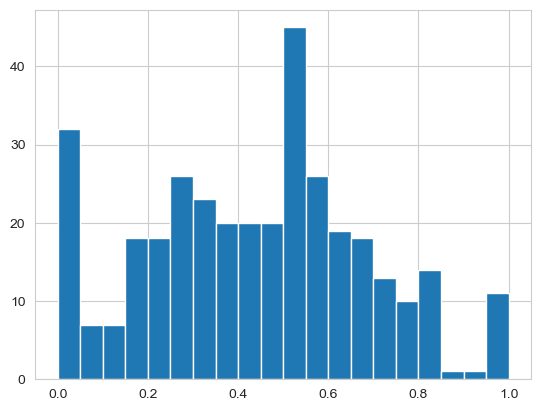

In [15]:
vafs = []
for i in range(100):
    gts = agt[:,i]
    alts = aalt[:,i]
    refs = aref[:,i]
    
    # print(list(np.unique(gts)))
    if "R" in list(np.unique(gts)) and "H" in list(np.unique(gts)):
        ind = np.where(gts == "H")
        vafs.extend(list(alts[ind]/(alts[ind]+refs[ind])))
        # print("ok")
        
        
plt.hist(vafs, bins=20)
plt.show()

In [16]:
def total_log_likelihood(params, k_obs, N_obs, genotypes):
    """
    Computes the total log-likelihood for the given parameters and observations.
    """
    dropout_prob, dropout_direction_prob, overdispersion, error_rate, alpha_h, beta_h = params
    log_likelihood = 0
    num_obs = len(k_obs)
    log_likelihoods = []

    for k, n, genotype in zip(k_obs, N_obs, genotypes):
        if genotype == "R":
            # Homozygous dominant: no dropout
            alpha = error_rate * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)

        elif genotype == "H":
            # Heterozygous: apply dropout
        
            # No dropout likelihood
            log_no_dropout = np.log(1 - dropout_prob) + beta_binomial_log_likelihood(k, n, alpha_h, beta_h)
        
            # Dropout to "AA"
            alpha_AA = error_rate * overdispersion
            beta_AA = overdispersion - alpha_AA
            log_dropout_AA = np.log(dropout_prob) + np.log(1 - dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_AA, beta_AA)
        
            # Dropout to "aa"
            alpha_aa = (1-error_rate) * overdispersion
            beta_aa = overdispersion - alpha_aa
            log_dropout_aa = np.log(dropout_prob) + np.log(dropout_direction_prob) + \
                beta_binomial_log_likelihood(k, n, alpha_aa, beta_aa)
        
            # Combine probabilities
            log_likelihood += logsumexp([log_no_dropout, log_dropout_AA, log_dropout_aa])
            
            # if log_no_dropout < log_dropout_aa:
            #     print("ok", k, n, log_no_dropout, log_dropout_aa)
        

            log_likelihoods.append(logsumexp([log_no_dropout, log_dropout_AA, log_dropout_aa]))
            
        elif genotype == "A":
            # Homozygous recessive: no dropout
            alpha = (1-error_rate) * overdispersion
            beta = overdispersion - alpha
            log_likelihood += beta_binomial_log_likelihood(k, n, alpha, beta)
            

        else:
            raise ValueError(f"Unexpected genotype: {genotype}")

    return -log_likelihood/num_obs, np.sum(log_likelihoods)  # Negative because we're minimizing


print(total_log_likelihood(fitted_params, k_obs_nonzero, N_nonzero, genotypes))
print(total_log_likelihood([0.5, 0.5, 10, 0.05, 2, 2], k_obs_nonzero, N_nonzero, genotypes))

(3.0456092851755807, -3374.2690042566205)
(3.2517674521660136, -3630.284396950811)


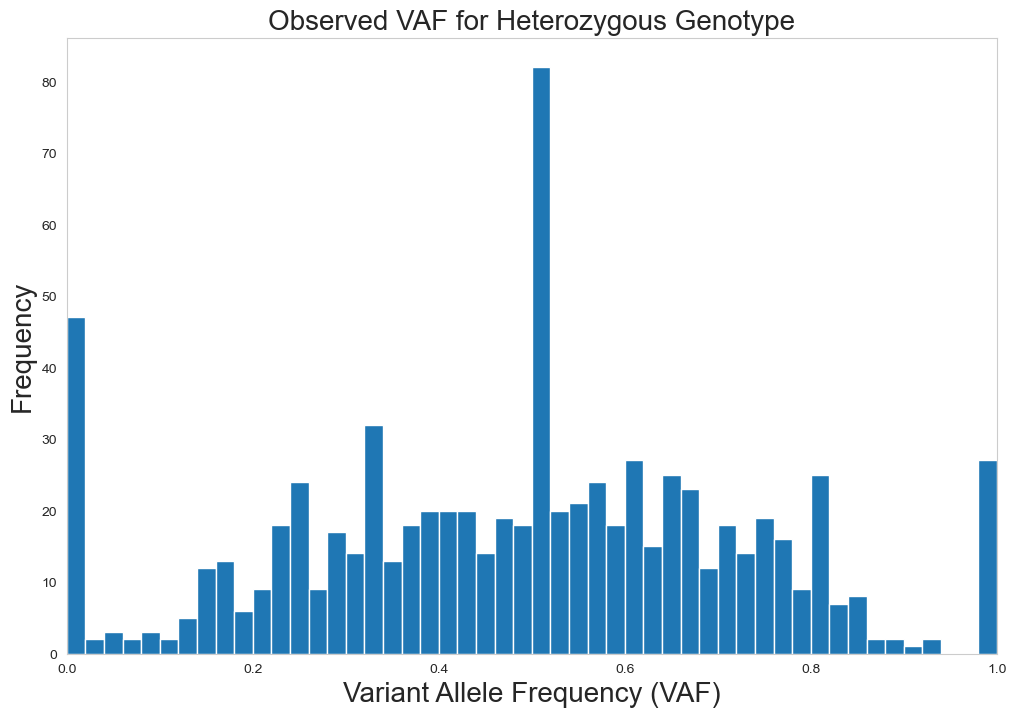

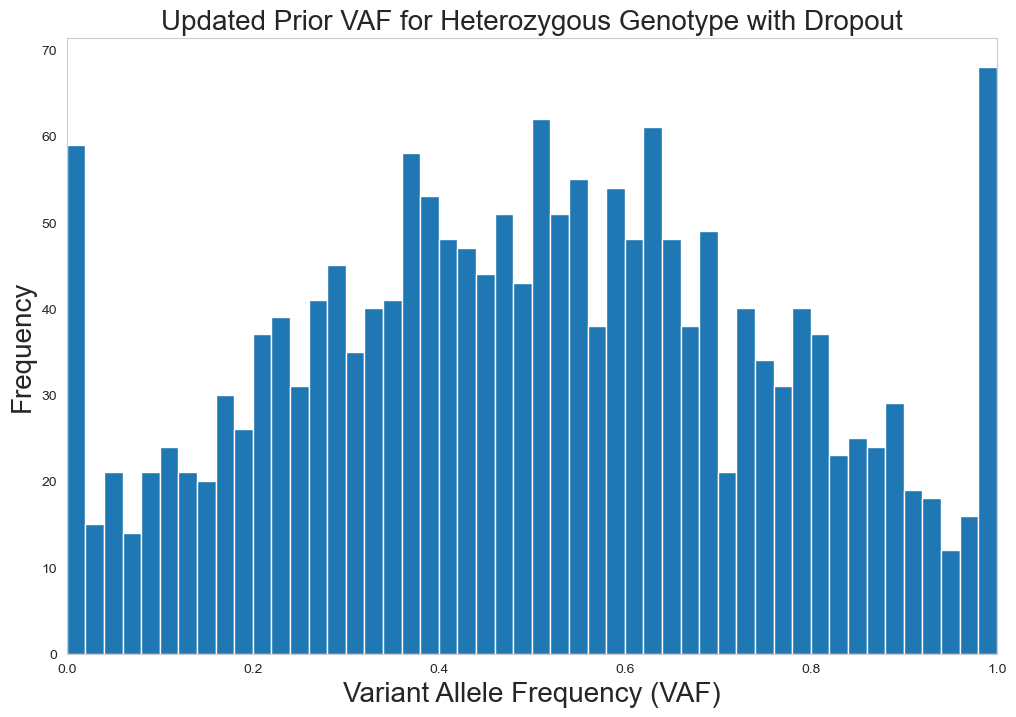

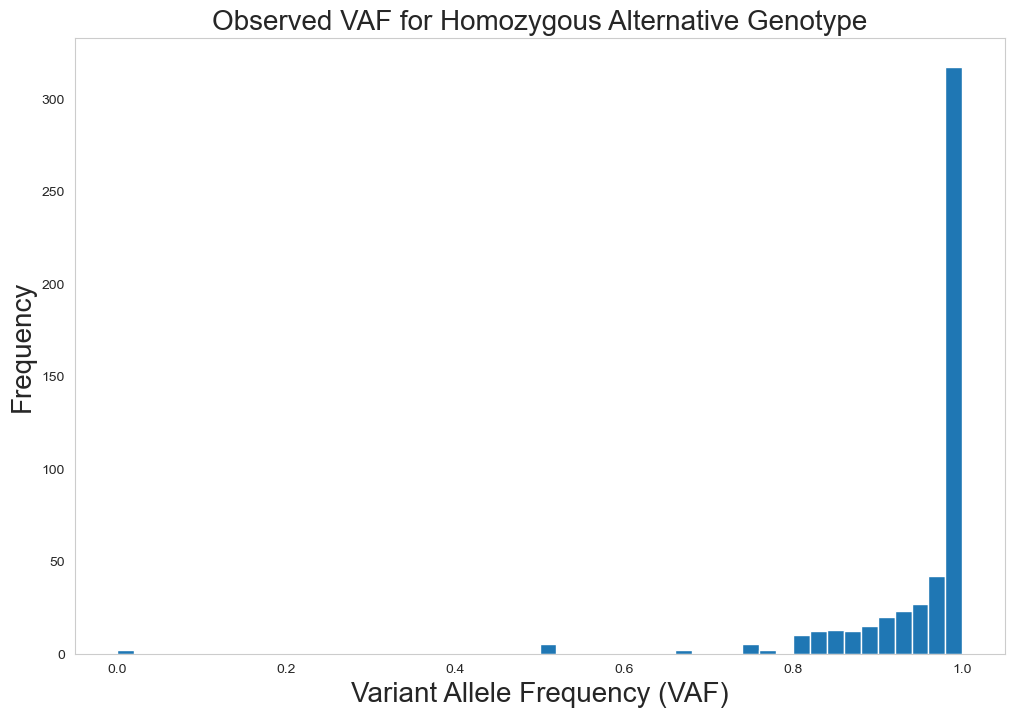

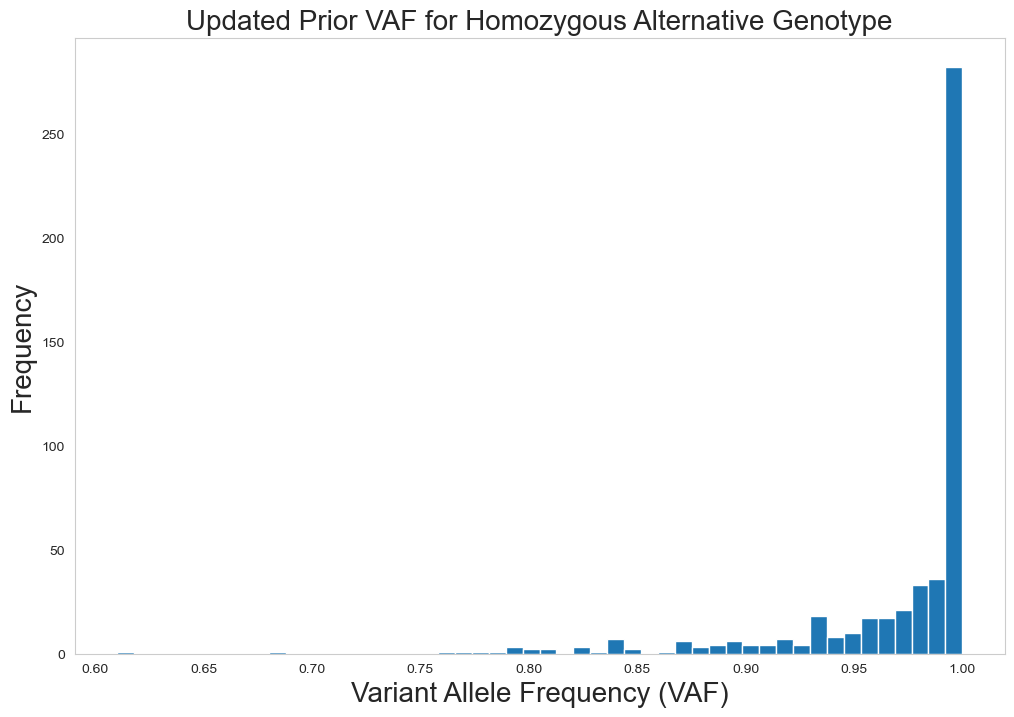

In [17]:
N = 300                 # Read depth
num_simulations = len(N_nonzero) # Number of simulations

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "H")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Heterozygous Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# dropout_prob, dropout_direction_prob, alpha_h, beta_h, error_rate, overdispersion  = 0.01, 0.5, 3, 3, 0.1, 0.18
vaf_counts = simulate_vaf_counts(alpha_h, beta_h, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Updated Prior VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.xlim([0, 1])
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

plt.figure(figsize=(12, 8))
indices = np.where(np.array(genotypes) == "A")[0]
plt.hist((k_obs_nonzero/N_nonzero)[indices], bins=50)
plt.title("Observed VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()

alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=len(indices)) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=50)
plt.title("Updated Prior VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)
plt.show()

In [1]:
import numpy as np

def create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped):
    n_cells = mutation_matrix.shape[0]
    n_loci = len(selected) + len(not_selected_genotypes)
    genotype_matrix = np.full((n_cells, n_loci), "", dtype="str")

    not_selected = [i for i in range(n_loci) if i not in selected]

    # Assign genotypes for loci not selected for tree learning
    for n, locus in enumerate(not_selected):
        genotype_matrix[:, locus] = not_selected_genotypes[n]

    # Assign genotypes for loci selected for tree learning
    for n, locus in enumerate(selected):
        if flipped[n]:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt2[n],
                np.where(mutation_matrix[:, n] == 1, gt1[n], mutation_matrix[:, n])
            )
        else:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt1[n],
                np.where(mutation_matrix[:, n] == 1, gt2[n], mutation_matrix[:, n])
            )

    return genotype_matrix

def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_cells = len(parent_vector)
    n_leaves = int((n_cells+1)/2)
    n_mutations = len(mutation_indices)

    # Initialize mutation matrix with zeros
    mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)

    # Mark cells with mutations
    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves]

  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing cell lineage tree ...
-4696.649730129961 -4696.649730129961
Optimizing mutation tree ...
after Node reattachment  -4696.649730129961
-4688.224175204566 -4693.369028843214
Optimizing cell lineage tree ...
-4680.737094104726 -4680.737094104726
Optimizing mutation tree ...
after Node reattachment  -4680.737094104726
-4678.328651822316 -4678.914436523894
Optimizing cell lineage tree ...
-4677.42994523273 -4677.4299452327305
Optimizing mutation tree ...
after Node reattachment  -4677.4299452327305
-4677.42994523273 -4677.4299452327305
Optimizing cell lineage tree ...
-4677.42994523273 -4677.42994523273
377
Global parameters: [0.01       0.86372086 8.8587019  0.05675493 4.16681068 4.18119034]


C:\Users\Norio\AppData\Local\Temp\ipykernel_28160\1657495146.py:58: RuntimeWarning: invalid value encountered in divide
  vaf = alt[indices]/(ref[indices]+alt[indices])


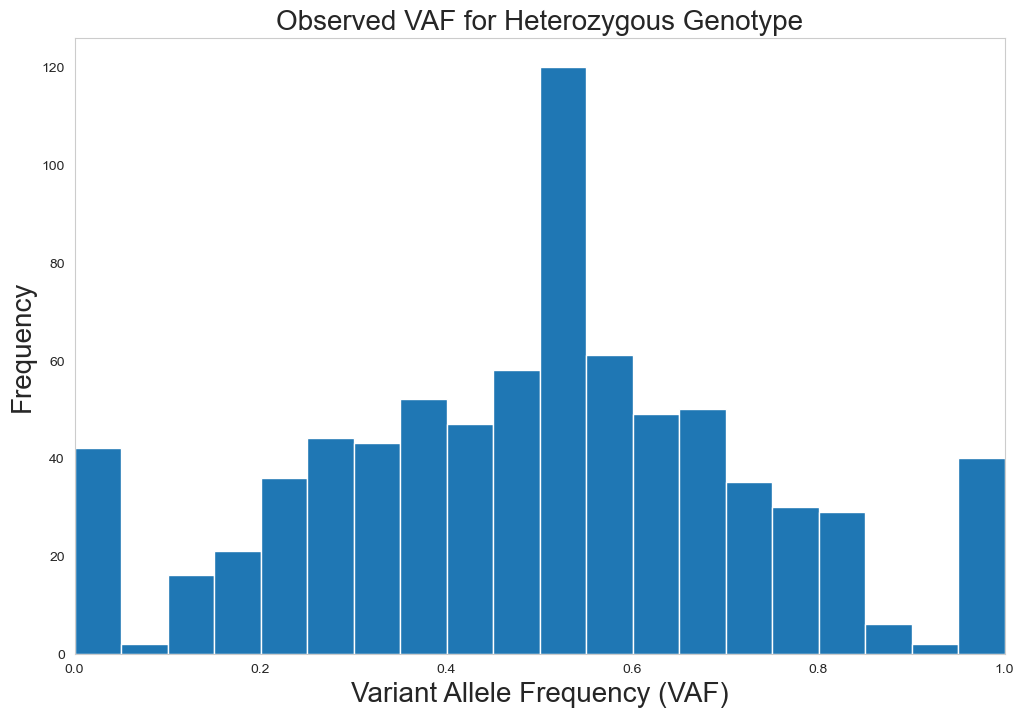

100%|██████████| 1/1 [00:18<00:00, 18.34s/it]

Round 0  (0.01, 0.8637208637789217, 8.858701895162703, 0.056754934005382375, 4.166810676109366, 4.1811903393035985)


In [4]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml

from src_python.data_generator import DataGenerator
from src_python.mutation_tree import MutationTree
from src_python.noise_mutation_filter import MutationFilter
from src_python.swap_optimizer import SwapOptimizer

with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

seed = config["random_seed"]
np.random.seed(seed)

path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\50c100m"

optimizer = SwapOptimizer(spaces = ["c", "m"], reverse_mutations=True)
total_rounds = 1

error_rate = config["error_rate"]
overdispersion=config["overdispersion"]
genotype_freq=config["genotype_freq"] 
mut_freq=config["mut_freq"]
alpha_h=config["alpha_h"]
beta_h=config["beta_h"]
dropout_prob=config["dropout_prob"]
dropout_direction_prob=config["dropout_direction_prob"]

for i in tqdm(range(10, 11)):
    
    alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
    ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T

    for round in range(total_rounds):
        mf = MutationFilter(error_rate= error_rate, overdispersion=overdispersion,
                            genotype_freq=genotype_freq, mut_freq=mut_freq,
                            alpha_h=alpha_h, beta_h=beta_h,
                        dropout_prob=dropout_prob, dropout_direction_prob=dropout_direction_prob)
        selected, gt1, gt2, not_selected_genotypes = mf.filter_mutations(ref, alt, method='first_k', n_exp=100, t=0.5) #  method='threshold', t=0.5,
        llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2)
    
        optimizer.fit_llh(llh_1, llh_2)
        optimizer.optimize()
        mutation_matrix = create_mutation_matrix(optimizer.ct.parent_vec, optimizer.ct.mut_loc, optimizer.ct)
        flipped = optimizer.ct.flipped
        genotype = create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped)
        genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
        
        print(np.sum(genotype != genotype_gt))
                                 
        params = mf.update_parameters(ref, alt, genotype_gt)
        
        plt.figure(figsize=(12, 8))
        indices = np.where(np.array(genotype_gt) == "H")
        vaf = alt[indices]/(ref[indices]+alt[indices])
        plt.hist(vaf, bins=20)
        plt.title("Observed VAF for Heterozygous Genotype", fontsize=20)
        plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
        plt.ylabel("Frequency", fontsize=20)
        plt.xlim([0, 1])
        plt.grid(False)
        plt.show()
        
        dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs = params
        print(f"Round {round} ", params)